In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import ast
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

Using device: cuda


In [ ]:
df_train = pd.read_csv('nutrigen_instructions_train.csv')
df_test = pd.read_csv('nutrigen_instructions_test.csv')

In [ ]:
def parse_ingredients(ingredients_str):
    """Parse ingredients from string to list"""
    try:
        return ast.literal_eval(ingredients_str)
    except:
        return re.findall(r"'(.*?)'", ingredients_str)

df_train['ingredients_list'] = df_train['ingredients'].apply(parse_ingredients)
df_test['ingredients_list'] = df_test['ingredients'].apply(parse_ingredients)

In [ ]:
def format_ingredients_for_input(ingredients_list, nutrition_info):
    """Format ingredients + nutrition as input sequence"""
    ingredients_str = ', '.join(ingredients_list)

    nutrition_str = f" [CALORIES: {nutrition_info['calories']:.0f}] [PROTEIN: {nutrition_info['protein']:.1f}g] [CARBS: {nutrition_info['carbs']:.1f}g] [FAT: {nutrition_info['fat']:.1f}g]"

    return ingredients_str + nutrition_str

df_train['input_sequence'] = df_train.apply(
    lambda row: format_ingredients_for_input(
        row['ingredients_list'],
        {
            'calories': row['calories'],
            'protein': row['protein'],
            'carbs': row['carbs'],
            'fat': row['fat']
        }
    ), axis=1
)

df_test['input_sequence'] = df_test.apply(
    lambda row: format_ingredients_for_input(
        row['ingredients_list'],
        {
            'calories': row['calories'],
            'protein': row['protein'],
            'carbs': row['carbs'],
            'fat': row['fat']
        }
    ), axis=1
)

print("Sample input-output pairs:")
for i in range(2):
    print(f"\nInput {i+1}: {df_train['input_sequence'].iloc[i][:100]}...")
    print(f"Output {i+1}: {df_train['instructions'].iloc[i][:100]}...")

Sample input-output pairs:

Input 1: 1 (20 ounce) can crushed pineapple, drained, 1 (3 ounce) package instant pistachio pudding mix, 1 (8...
Output 1: Combine pineapple and dry pistachio pudding mix in a large bowl. Fold in thawed whipped topping and ...

Input 2: 1 pound cooked and drained spaghetti, 5 chicken breasts, cooked and cubed, 2 (10.75 ounce) cans cond...
Output 2: Put cooked spaghetti into 9x13-inch baking dish. Place chicken on top of spaghetti. In medium saucep...


### Custom Tokenizer and Vocabulary

In [ ]:
class RecipeTokenizer:

    def __init__(self, min_freq=2):
        self.min_freq = min_freq
        self.word2idx = {}
        self.idx2word = {}
        self.vocab_size = 0

        self.pad_token = '<pad>'
        self.sos_token = '<sos>'
        self.eos_token = '<eos>'
        self.unk_token = '<unk>'

    def fit(self, texts):
        """Build vocabulary from training texts"""
        all_words = []
        for text in texts:
            words = self._tokenize_text(text)
            all_words.extend(words)

        word_counts = Counter(all_words)

        vocab_words = [word for word, count in word_counts.items() if count >= self.min_freq]

        self.word2idx = {
            self.pad_token: 0,
            self.sos_token: 1,
            self.eos_token: 2,
            self.unk_token: 3
        }

        for i, word in enumerate(vocab_words, 4):
            self.word2idx[word] = i

        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)

        print(f"Built vocabulary with {self.vocab_size:,} tokens")

    def _tokenize_text(self, text):
        """Simple whitespace tokenization with punctuation handling"""
        text = str(text).lower()

        words = re.findall(r"\b\w+\b|[.,!?;()]", text)

        return words

    def encode(self, text, max_length=None, add_special_tokens=True):
        """Convert text to token ids"""
        words = self._tokenize_text(text)

        if add_special_tokens:
            tokens = [self.sos_token] + words + [self.eos_token]
        else:
            tokens = words

        # Convert to indices
        indices = []
        for token in tokens:
            if token in self.word2idx:
                indices.append(self.word2idx[token])
            else:
                indices.append(self.word2idx[self.unk_token])

        # Truncate if needed
        if max_length:
            indices = indices[:max_length]

        return indices

    def decode(self, indices, skip_special_tokens=True):
        """Convert token ids back to text"""
        words = []
        for idx in indices:
            if idx in self.idx2word:
                word = self.idx2word[idx]
                if skip_special_tokens and word in [self.pad_token, self.sos_token, self.eos_token]:
                    continue
                elif skip_special_tokens and word == self.unk_token:
                    continue
                words.append(word)

        return ' '.join(words)

    def save(self, filepath):
        """Save tokenizer to file"""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'word2idx': self.word2idx,
                'idx2word': self.idx2word,
                'vocab_size': self.vocab_size,
                'min_freq': self.min_freq
            }, f)

    @classmethod
    def load(cls, filepath):
        """Load tokenizer from file"""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)

        tokenizer = cls(min_freq=data['min_freq'])
        tokenizer.word2idx = data['word2idx']
        tokenizer.idx2word = data['idx2word']
        tokenizer.vocab_size = data['vocab_size']

        return tokenizer

In [ ]:
all_texts = list(df_train['input_sequence']) + list(df_train['instructions'])

tokenizer = RecipeTokenizer(min_freq=3)
tokenizer.fit(all_texts)

print(f"\nVocabulary size: {tokenizer.vocab_size:,}")
print(f"Most common tokens: {list(tokenizer.word2idx.keys())[:20]}")

Built vocabulary with 7,609 tokens

Vocabulary size: 7,609
Most common tokens: ['<pad>', '<sos>', '<eos>', '<unk>', '1', '(', '20', 'ounce', ')', 'can', 'crushed', 'pineapple', ',', 'drained', '3', 'package', 'instant', 'pistachio', 'pudding', 'mix']


In [ ]:
class RecipeDataset(Dataset):
    """Dataset for recipe instruction generation"""

    def __init__(self, df, tokenizer, max_input_length=200, max_output_length=300):
        self.df = df
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Encode input (ingredients + nutrition)
        input_ids = self.tokenizer.encode(
            row['input_sequence'],
            max_length=self.max_input_length
        )

        # Encode output (instructions)
        output_ids = self.tokenizer.encode(
            row['instructions'],
            max_length=self.max_output_length
        )

        # Create decoder input (shifted output)
        decoder_input_ids = output_ids[:-1]  # Remove last token
        decoder_target_ids = output_ids[1:]  # Remove first token (<sos>)

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'decoder_input_ids': torch.tensor(decoder_input_ids, dtype=torch.long),
            'decoder_target_ids': torch.tensor(decoder_target_ids, dtype=torch.long)
        }

def collate_fn(batch):
    """Collate function for variable-length sequences"""
    input_ids = [item['input_ids'] for item in batch]
    decoder_input_ids = [item['decoder_input_ids'] for item in batch]
    decoder_target_ids = [item['decoder_target_ids'] for item in batch]

    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
    decoder_input_ids = torch.nn.utils.rnn.pad_sequence(decoder_input_ids, batch_first=True, padding_value=0)
    decoder_target_ids = torch.nn.utils.rnn.pad_sequence(decoder_target_ids, batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids,
        'decoder_input_ids': decoder_input_ids,
        'decoder_target_ids': decoder_target_ids
    }

In [ ]:
train_dataset = RecipeDataset(df_train, tokenizer)
test_dataset = RecipeDataset(df_test, tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

sample_batch = next(iter(train_loader))
print(f"\nSample batch shapes:")
print(f"Input: {sample_batch['input_ids'].shape}")
print(f"Decoder input: {sample_batch['decoder_input_ids'].shape}")
print(f"Decoder target: {sample_batch['decoder_target_ids'].shape}")

Training batches: 1658
Test batches: 415

Sample batch shapes:
Input: torch.Size([16, 142])
Decoder input: torch.Size([16, 299])
Decoder target: torch.Size([16, 299])


In [ ]:
class RecipeTransformer(nn.Module):
    """Sequence-to-sequence transformer for recipe instruction generation"""

    def __init__(self, vocab_size, d_model=512, n_heads=8, n_layers=6, d_ff=2048, dropout=0.1):
        super(RecipeTransformer, self).__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model

        self.encoder_embedding = nn.Embedding(vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(vocab_size, d_model)

        self.positional_encoding = self._create_positional_encoding(1000, d_model)

        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=n_heads,
            num_encoder_layers=n_layers,
            num_decoder_layers=n_layers,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )

        self.output_layer = nn.Linear(d_model, vocab_size)

        self.dropout = nn.Dropout(dropout)

    def _create_positional_encoding(self, max_len, d_model):
        """Create positional encoding matrix"""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        return nn.Parameter(pe, requires_grad=False)

    def forward(self, src, tgt):
        """Forward pass"""
        src_mask = self._generate_square_subsequent_mask(src.size(1)).to(src.device)
        tgt_mask = self._generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)

        # Embeddings + positional encoding
        src_emb = self.dropout(self.encoder_embedding(src) + self.positional_encoding[:, :src.size(1), :])
        tgt_emb = self.dropout(self.decoder_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :])

        output = self.transformer(
            src_emb, tgt_emb,
            src_mask=src_mask,
            tgt_mask=tgt_mask
        )


        output = self.output_layer(output)

        return output

    def _generate_square_subsequent_mask(self, sz):
        """Generate mask for transformer decoder"""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def generate(self, src, max_length=100, temperature=1.0, top_k=None):
        """Generate sequence autoregressively"""
        self.eval()

        with torch.no_grad():
            # Encode source
            src_emb = self.dropout(self.encoder_embedding(src) + self.positional_encoding[:, :src.size(1), :])
            # src_emb = src_emb.transpose(0, 1)

            # Get memory from encoder
            memory = self.transformer.encoder(src_emb)

            # Start with <sos> token
            generated = torch.tensor([[tokenizer.word2idx[tokenizer.sos_token]]], device=src.device)

            for _ in range(max_length):
                # Embed current sequence
                tgt_emb = self.dropout(self.decoder_embedding(generated) + self.positional_encoding[:, :generated.size(1), :])

                # Create mask
                tgt_mask = self._generate_square_subsequent_mask(generated.size(1)).to(generated.device)

                # Decode
                output = self.transformer.decoder(tgt_emb, memory, tgt_mask=tgt_mask)

                # Get next token logits
                logits = self.output_layer(output[:, -1, :])

                # Apply temperature
                logits = logits / temperature

                # Apply top-k filtering if specified
                if top_k:
                    top_k_logits, top_k_indices = torch.topk(logits, top_k, dim=-1)
                    logits = torch.full_like(logits, float('-inf'))
                    logits.scatter_(1, top_k_indices, top_k_logits)

                # Sample or greedy decode
                probs = torch.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, 1).squeeze(-1)

                # Append to sequence
                generated = torch.cat([generated, next_token.unsqueeze(0)], dim=1)

                # Stop if EOS token
                if next_token.item() == tokenizer.word2idx[tokenizer.eos_token]:
                    break

            return generated.squeeze(0)

In [ ]:
model = RecipeTransformer(
    vocab_size=tokenizer.vocab_size,
    d_model=256,
    n_heads=8,
    n_layers=4, 
    d_ff=1024,
    dropout=0.1
)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.1f} MB")

Model parameters: 13,481,145
Trainable parameters: 13,225,145
Model size: 51.4 MB


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word2idx[tokenizer.pad_token])
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

num_epochs = 10
gradient_clip = 1.0

train_losses = []
test_losses = []
learning_rates = []

def train_epoch(model, dataloader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        decoder_input_ids = batch['decoder_input_ids'].to(device)
        decoder_target_ids = batch['decoder_target_ids'].to(device)

        optimizer.zero_grad()
        output = model(input_ids, decoder_input_ids)

        output = output.view(-1, output.size(-1))
        targets = decoder_target_ids.view(-1)

        loss = criterion(output, targets)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)

        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    return total_loss / len(dataloader)

In [47]:
def evaluate(model, dataloader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            decoder_input_ids = batch['decoder_input_ids'].to(device)
            decoder_target_ids = batch['decoder_target_ids'].to(device)

            output = model(input_ids, decoder_input_ids)
            output = output.view(-1, output.size(-1))
            targets = decoder_target_ids.view(-1)

            loss = criterion(output, targets)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    test_loss = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")

    if (epoch + 1) % 5 == 0:
        checkpoint_path = f"models/transformer_epoch_{epoch+1}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss
        }, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.1f} minutes")

Starting training...

Epoch 1/10


Train Loss: 3.8463
Test Loss: 2.9816
Learning Rate: 0.000100

Epoch 2/10


Train Loss: 2.8628
Test Loss: 2.5661
Learning Rate: 0.000100

Epoch 3/10


Train Loss: 2.5711
Test Loss: 2.3654
Learning Rate: 0.000100

Epoch 4/10


Train Loss: 2.4046
Test Loss: 2.2367
Learning Rate: 0.000100

Epoch 5/10


Train Loss: 2.2894
Test Loss: 2.1420
Learning Rate: 0.000090
Checkpoint saved: models/transformer_epoch_5.pt

Epoch 6/10


Train Loss: 2.1998
Test Loss: 2.0742
Learning Rate: 0.000090

Epoch 7/10


Train Loss: 2.1330
Test Loss: 2.0207
Learning Rate: 0.000090

Epoch 8/10


Train Loss: 2.0750
Test Loss: 1.9756
Learning Rate: 0.000090

Epoch 9/10


Train Loss: 2.0280
Test Loss: 1.9398
Learning Rate: 0.000090

Epoch 10/10


Train Loss: 1.9852
Test Loss: 1.9074
Learning Rate: 0.000081
Checkpoint saved: models/transformer_epoch_10.pt

Training completed in 11.4 minutes


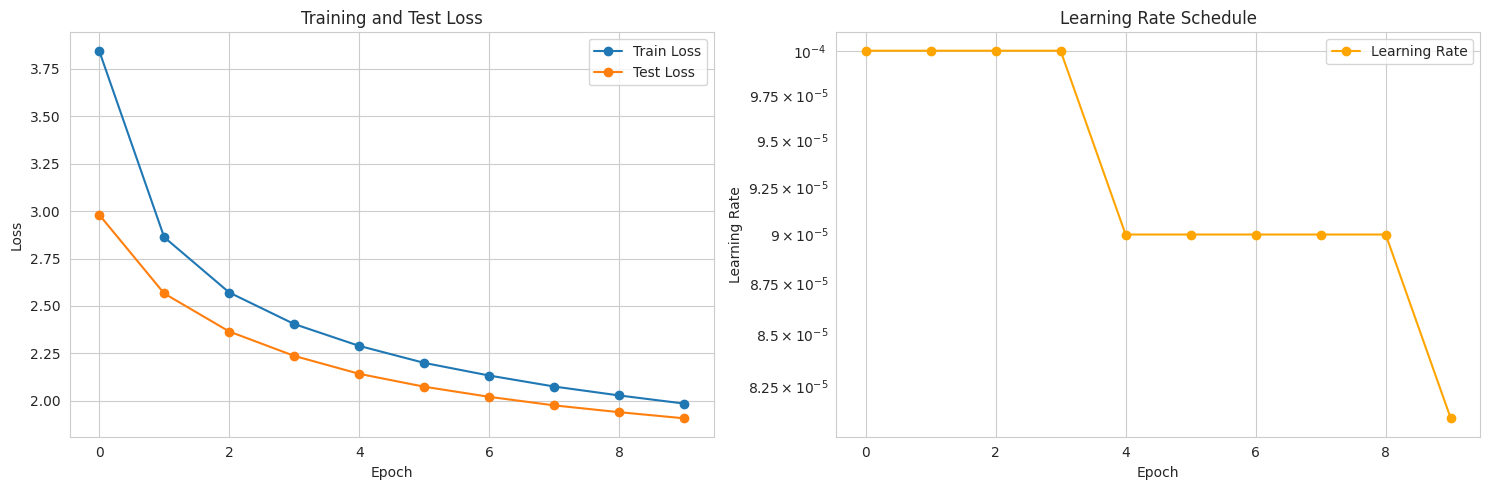

Final train loss: 1.9852
Final test loss: 1.9074
Best test loss: 1.9074 (epoch 10)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(test_losses, label='Test Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(learning_rates, label='Learning Rate', marker='o', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final test loss: {test_losses[-1]:.4f}")
print(f"Best test loss: {min(test_losses):.4f} (epoch {test_losses.index(min(test_losses))+1})")

In [ ]:
checkpoint = torch.load('models/transformer_epoch_10.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print("Loaded best model checkpoint")

model.eval()

def generate_instructions(model, tokenizer, input_text, max_length=150, temperature=0.8, top_k=50):
    """Generate cooking instructions for given ingredients"""
    # Encode input
    input_ids = tokenizer.encode(input_text, max_length=200)
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

    # Generate
    generated_ids = model.generate(
        input_tensor,
        max_length=max_length,
        temperature=temperature,
        top_k=top_k
    )

    # Decode
    generated_text = tokenizer.decode(generated_ids.tolist())

    return generated_text

Loaded best model checkpoint


In [51]:
# Test generation on sample inputs
test_samples = df_test.sample(5, random_state=42)

print("Sample Generation Results:")

for i, (_, row) in enumerate(test_samples.iterrows()):
    print(f"\nSample {i+1}")
    print("-"*40)

    # Input ingredients
    input_text = row['input_sequence']
    print(f"Ingredients: {input_text[:150]}...")

    # Ground truth instructions
    true_instructions = row['instructions']
    print(f"\nTrue Instructions: {true_instructions[:200]}...")

    # Generated instructions
    try:
        generated_instructions = generate_instructions(model, tokenizer, input_text)
        print(f"\nGenerated Instructions: {generated_instructions[:200]}...")
    except Exception as e:
        print(f"\nGeneration Error: {e}")



Sample Generation Results:

Sample 1
----------------------------------------
Ingredients: 0.5 cup butter, 1 (15.25 ounce) package spice cake mix with pudding (such as Betty Crocker짰), 4 eggs, at room temperature, 1 cup pumpkin puree, 0.5 cu...

True Instructions: Preheat the oven to 350 degrees F (175 degrees C). Grease a 9x13-inch baking dish. Microwave butter in a bowl for 30 seconds and stir. Continue to microwave at 10-second intervals until butter is comp...

Generated Instructions: preheat the oven to 350 degrees f cake pans cake pans , lightly cake pans cake pans cake pans with cake cake pans cake cake cake cake cake cake pans cake cake cake cake cake cake cake cake cake cake c...

Sample 2
----------------------------------------
Ingredients: 3 tablespoons light brown sugar, 2 tablespoons sea salt, 1 tablespoon ground white pepper, 1 tablespoon onion powder, 2 teaspoons cayenne pepper, 1.5 ...

True Instructions: About one hour before smoking, make the dry rub. Combine sugar, 

The model is not performing well
- Repetitive, incoherent text
- no logical flow

learning rate is TOO HIGH. causes exploding gradients and unstable training

In [52]:
class FixedRecipeTransformer(nn.Module):
    """Fixed transformer with stable training"""

    def __init__(self, vocab_size, d_model=256, n_heads=8, n_layers=4, d_ff=1024, dropout=0.1):
        super(FixedRecipeTransformer, self).__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model

        # Embeddings
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = PositionalEncoding(d_model, dropout)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=n_heads,
            num_encoder_layers=n_layers,
            num_decoder_layers=n_layers,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )

        # Output
        self.fc_out = nn.Linear(d_model, vocab_size)

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        """Proper initialization prevents exploding gradients"""
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p, gain=1.0)

    def forward(self, src, tgt, src_padding_mask=None, tgt_padding_mask=None):
        """Forward with proper masks"""

        # Scale embeddings (CRITICAL!)
        src_emb = self.embedding(src) * np.sqrt(self.d_model)
        tgt_emb = self.embedding(tgt) * np.sqrt(self.d_model)

        # Positional encoding
        src_emb = self.pos_encoding(src_emb)
        tgt_emb = self.pos_encoding(tgt_emb)

        # Causal mask for decoder
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(
            tgt.size(1), device=tgt.device
        )

        # Transformer
        output = self.transformer(
            src_emb,
            tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )

        return self.fc_out(output)



In [53]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].unsqueeze(0)
        return self.dropout(x)


# FIXED COLLATE FUNCTION
def fixed_collate_fn(batch, pad_idx=0):
    """Proper batching with masks"""
    input_ids = [item['input_ids'] for item in batch]
    decoder_input_ids = [item['decoder_input_ids'] for item in batch]
    decoder_target_ids = [item['decoder_target_ids'] for item in batch]

    # Pad
    input_padded = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=pad_idx)
    decoder_input_padded = nn.utils.rnn.pad_sequence(decoder_input_ids, batch_first=True, padding_value=pad_idx)
    decoder_target_padded = nn.utils.rnn.pad_sequence(decoder_target_ids, batch_first=True, padding_value=pad_idx)

    # Masks (True = padding)
    src_mask = (input_padded == pad_idx)
    tgt_mask = (decoder_input_padded == pad_idx)

    return {
        'input_ids': input_padded,
        'decoder_input_ids': decoder_input_padded,
        'decoder_target_ids': decoder_target_padded,
        'src_mask': src_mask,
        'tgt_mask': tgt_mask
    }

In [54]:
class TransformerLRScheduler:
    """Proper warmup schedule for transformers"""

    def __init__(self, optimizer, d_model, warmup_steps=4000):
        self.optimizer = optimizer
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.step_num = 0

    def step(self):
        self.step_num += 1
        lr = self._get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def _get_lr(self):
        # Original transformer learning rate schedule
        step = max(1, self.step_num)
        return (self.d_model ** -0.5) * min(step ** -0.5, step * self.warmup_steps ** -1.5)

    def get_last_lr(self):
        return [self._get_lr()]

In [55]:
# STABLE TRAINING LOOP
def train_epoch_stable(model, dataloader, optimizer, scheduler, criterion, device, grad_clip=1.0):
    """Training loop with gradient monitoring"""
    model.train()
    total_loss = 0
    total_tokens = 0
    grad_norms = []

    progress_bar = tqdm(dataloader, desc="Training")

    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        src = batch['input_ids'].to(device)
        tgt_input = batch['decoder_input_ids'].to(device)
        tgt_output = batch['decoder_target_ids'].to(device)
        src_mask = batch['src_mask'].to(device)
        tgt_mask = batch['tgt_mask'].to(device)

        # Forward
        optimizer.zero_grad()

        try:
            logits = model(src, tgt_input, src_mask, tgt_mask)

            # Loss (flatten, ignore padding)
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                tgt_output.reshape(-1)
            )

            # Check for NaN
            if torch.isnan(loss):
                print(f"\nWARNING: NaN loss at batch {batch_idx}! Skipping...")
                continue

            # Backward
            loss.backward()

            # Check gradient norm BEFORE clipping
            total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            grad_norms.append(total_norm.item())

            # Update
            optimizer.step()
            scheduler.step()

            # Track
            n_tokens = (tgt_output != 0).sum().item()
            total_loss += loss.item() * n_tokens
            total_tokens += n_tokens

            # Progress
            current_lr = scheduler.get_last_lr()[0]
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'lr': f"{current_lr:.2e}",
                'grad': f"{total_norm:.2f}"
            })

        except RuntimeError as e:
            print(f"\nERROR at batch {batch_idx}: {e}")
            continue

    avg_loss = total_loss / total_tokens
    avg_grad = np.mean(grad_norms) if grad_norms else 0

    return avg_loss, avg_grad

In [56]:
# EVALUATION FUNCTION
def evaluate_model(model, dataloader, criterion, device):
    """Evaluate without training"""
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            src = batch['input_ids'].to(device)
            tgt_input = batch['decoder_input_ids'].to(device)
            tgt_output = batch['decoder_target_ids'].to(device)
            src_mask = batch['src_mask'].to(device)
            tgt_mask = batch['tgt_mask'].to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask)
            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                tgt_output.reshape(-1)
            )

            n_tokens = (tgt_output != 0).sum().item()
            total_loss += loss.item() * n_tokens
            total_tokens += n_tokens

    return total_loss / total_tokens

In [57]:
def train_recipe_transformer(train_loader, val_loader, vocab_size, device, num_epochs=20):
    """Complete training pipeline with monitoring"""

    # Model
    model = FixedRecipeTransformer(
        vocab_size=vocab_size,
        d_model=256,      # Start smaller
        n_heads=8,
        n_layers=4,
        d_ff=1024,
        dropout=0.1
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss (with label smoothing)
    criterion = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.1)

    # Optimizer - CORRECTED: Use proper initial lr
    optimizer = optim.Adam(
        model.parameters(),
        lr=0.0001,  # Will be overridden by scheduler
        betas=(0.9, 0.98),
        eps=1e-9
    )

    scheduler = TransformerLRScheduler(
        optimizer,
        d_model=256,
        warmup_steps=4000  # This prevents initial high lr spike!
    )

    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, avg_grad = train_epoch_stable(
            model, train_loader, optimizer, scheduler, criterion, device
        )
        train_losses.append(train_loss)

        # Validate
        val_loss = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        # Metrics
        train_ppl = np.exp(train_loss)
        val_ppl = np.exp(val_loss)

        print(f"\nResults:")
        print(f"  Train Loss: {train_loss:.4f} | Perplexity: {train_ppl:.2f}")
        print(f"  Val Loss:   {val_loss:.4f} | Perplexity: {val_ppl:.2f}")
        print(f"  Avg Gradient Norm: {avg_grad:.4f}")
        print(f"  Current LR: {scheduler.get_last_lr()[0]:.2e}")

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, 'best_recipe_model.pt')
            print(f" Saved new best model!")


    return model, train_losses, val_losses

In [58]:
# 1. Rebuild your dataloader with fixed collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=32,  # Increase if you have GPU memory
    shuffle=True,
    collate_fn=lambda b: fixed_collate_fn(b, pad_idx=0)
)

val_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda b: fixed_collate_fn(b, pad_idx=0)
)

# 2. Train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, train_losses, val_losses = train_recipe_transformer(
    train_loader,
    val_loader,
    vocab_size=tokenizer.vocab_size,
    device=device,
    num_epochs=20
)

Model parameters: 11,277,241
Epoch 1/20



Results:
  Train Loss: 5.8210 | Perplexity: 337.30
  Val Loss:   4.0990 | Perplexity: 60.28
  Avg Gradient Norm: 1.1261
  Current LR: 2.05e-04
 Saved new best model!
Epoch 2/20



Results:
  Train Loss: 3.7303 | Perplexity: 41.69
  Val Loss:   3.3995 | Perplexity: 29.95
  Avg Gradient Norm: 0.9532
  Current LR: 4.10e-04
 Saved new best model!
Epoch 3/20



Results:
  Train Loss: 3.2979 | Perplexity: 27.06
  Val Loss:   3.1813 | Perplexity: 24.08
  Avg Gradient Norm: 0.7998
  Current LR: 6.14e-04
 Saved new best model!
Epoch 4/20



Results:
  Train Loss: 3.0963 | Perplexity: 22.11
  Val Loss:   3.0784 | Perplexity: 21.72
  Avg Gradient Norm: 0.6751
  Current LR: 8.19e-04
 Saved new best model!
Epoch 5/20



Results:
  Train Loss: 2.9816 | Perplexity: 19.72
  Val Loss:   3.0313 | Perplexity: 20.72
  Avg Gradient Norm: 0.5955
  Current LR: 9.71e-04
 Saved new best model!
Epoch 6/20



Results:
  Train Loss: 2.8944 | Perplexity: 18.07
  Val Loss:   2.9779 | Perplexity: 19.65
  Avg Gradient Norm: 0.5512
  Current LR: 8.86e-04
 Saved new best model!
Epoch 7/20



Results:
  Train Loss: 2.8214 | Perplexity: 16.80
  Val Loss:   2.9535 | Perplexity: 19.17
  Avg Gradient Norm: 0.5287
  Current LR: 8.20e-04
 Saved new best model!
Epoch 8/20



Results:
  Train Loss: 2.7680 | Perplexity: 15.93
  Val Loss:   2.9546 | Perplexity: 19.19
  Avg Gradient Norm: 0.5226
  Current LR: 7.67e-04
Epoch 9/20



Results:
  Train Loss: 2.7249 | Perplexity: 15.25
  Val Loss:   2.9277 | Perplexity: 18.68
  Avg Gradient Norm: 0.5194
  Current LR: 7.24e-04
 Saved new best model!
Epoch 10/20



Results:
  Train Loss: 2.6902 | Perplexity: 14.73
  Val Loss:   2.9260 | Perplexity: 18.65
  Avg Gradient Norm: 0.5203
  Current LR: 6.86e-04
 Saved new best model!
Epoch 11/20



Results:
  Train Loss: 2.6602 | Perplexity: 14.30
  Val Loss:   2.9207 | Perplexity: 18.55
  Avg Gradient Norm: 0.5203
  Current LR: 6.54e-04
 Saved new best model!
Epoch 12/20



Results:
  Train Loss: 2.6338 | Perplexity: 13.93
  Val Loss:   2.9177 | Perplexity: 18.50
  Avg Gradient Norm: 0.5242
  Current LR: 6.27e-04
 Saved new best model!
Epoch 13/20



Results:
  Train Loss: 2.6108 | Perplexity: 13.61
  Val Loss:   2.9193 | Perplexity: 18.53
  Avg Gradient Norm: 0.5271
  Current LR: 6.02e-04
Epoch 14/20



Results:
  Train Loss: 2.5905 | Perplexity: 13.34
  Val Loss:   2.9218 | Perplexity: 18.57
  Avg Gradient Norm: 0.5301
  Current LR: 5.80e-04
Epoch 15/20



Results:
  Train Loss: 2.5727 | Perplexity: 13.10
  Val Loss:   2.9228 | Perplexity: 18.59
  Avg Gradient Norm: 0.5328
  Current LR: 5.60e-04
Epoch 16/20



Results:
  Train Loss: 2.5550 | Perplexity: 12.87
  Val Loss:   2.9302 | Perplexity: 18.73
  Avg Gradient Norm: 0.5371
  Current LR: 5.43e-04
Epoch 17/20



Results:
  Train Loss: 2.5392 | Perplexity: 12.67
  Val Loss:   2.9285 | Perplexity: 18.70
  Avg Gradient Norm: 0.5409
  Current LR: 5.26e-04
Epoch 18/20



Results:
  Train Loss: 2.5248 | Perplexity: 12.49
  Val Loss:   2.9301 | Perplexity: 18.73
  Avg Gradient Norm: 0.5443
  Current LR: 5.12e-04
Epoch 19/20



Results:
  Train Loss: 2.5112 | Perplexity: 12.32
  Val Loss:   2.9296 | Perplexity: 18.72
  Avg Gradient Norm: 0.5505
  Current LR: 4.98e-04
Epoch 20/20



Results:
  Train Loss: 2.4995 | Perplexity: 12.18
  Val Loss:   2.9323 | Perplexity: 18.77
  Avg Gradient Norm: 0.5543
  Current LR: 4.85e-04


In [61]:
import torch
import numpy as np
from tqdm import tqdm

def generate_recipe(model, tokenizer, input_text, max_length=200,
                   temperature=0.8, top_p=0.9, device='cuda'):
    """Generate recipe instructions with nucleus sampling"""
    model.eval()

    # Encode input
    input_ids = tokenizer.encode(input_text, max_length=150, add_special_tokens=True)
    src = torch.tensor([input_ids], dtype=torch.long).to(device)

    # Start with <sos>
    sos_idx = tokenizer.word2idx[tokenizer.sos_token]
    eos_idx = tokenizer.word2idx[tokenizer.eos_token]
    generated = torch.tensor([[sos_idx]], dtype=torch.long).to(device)

    with torch.no_grad():
        # Create source mask
        src_mask = (src == 0)

        for _ in range(max_length):
            # Create target mask
            tgt_mask = (generated == 0)

            # Forward pass
            logits = model(src, generated, src_mask, tgt_mask)
            next_token_logits = logits[0, -1, :] / temperature

            # Nucleus (top-p) sampling
            sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
            cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

            # Remove tokens with cumulative probability above threshold
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
            sorted_indices_to_remove[0] = 0

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            next_token_logits[indices_to_remove] = float('-inf')

            # Sample
            probs = torch.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, 1).unsqueeze(0)

            # Append
            generated = torch.cat([generated, next_token], dim=1)

            # Stop at EOS
            if next_token.item() == eos_idx:
                break

    # Decode
    generated_ids = generated[0].tolist()
    text = tokenizer.decode(generated_ids, skip_special_tokens=True)

    return text

In [62]:
# Test generation on sample inputs
test_samples = df_test.sample(5, random_state=42)

print("Sample Generation Results:")

for i, (_, row) in enumerate(test_samples.iterrows()):
    print(f"\nSample {i+1}")
    print("-"*40)

    # Input ingredients
    input_text = row['input_sequence']
    print(f"Ingredients: {input_text[:150]}...")

    # Ground truth instructions
    true_instructions = row['instructions']
    print(f"\nTrue Instructions: {true_instructions[:200]}...")

    # Generated instructions
    try:
        generated_instructions = generate_recipe(model, tokenizer, input_text)
        print(f"\nGenerated Instructions: {generated_instructions[:200]}...")
    except Exception as e:
        print(f"\nGeneration Error: {e}")

Sample Generation Results:

Sample 1
----------------------------------------
Ingredients: 0.5 cup butter, 1 (15.25 ounce) package spice cake mix with pudding (such as Betty Crocker짰), 4 eggs, at room temperature, 1 cup pumpkin puree, 0.5 cu...

True Instructions: Preheat the oven to 350 degrees F (175 degrees C). Grease a 9x13-inch baking dish. Microwave butter in a bowl for 30 seconds and stir. Continue to microwave at 10-second intervals until butter is comp...

Generated Instructions: in a large bowl , mix together the starter , water , butter , and sugar . cover , and refrigerate for at least 4 hours or overnight . in a separate bowl , combine the flour , baking powder and salt . ...

Sample 2
----------------------------------------
Ingredients: 3 tablespoons light brown sugar, 2 tablespoons sea salt, 1 tablespoon ground white pepper, 1 tablespoon onion powder, 2 teaspoons cayenne pepper, 1.5 ...

True Instructions: About one hour before smoking, make the dry rub. Combine sugar, 

In [65]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu_scores(model, tokenizer, test_df, device, n_samples=100):
    """Calculate BLEU scores for generated recipes"""

    samples = test_df.sample(min(n_samples, len(test_df)), random_state=42)
    bleu_scores = []
    smoothing = SmoothingFunction().method4

    for _, row in tqdm(samples.iterrows(), total=len(samples), desc="Evaluating"):
        try:
            # Generate
            generated = generate_recipe(
                model, tokenizer, row['input_sequence'],
                temperature=0.8, device=device
            )

            # Tokenize
            reference = row['instructions'].lower().split()
            hypothesis = generated.lower().split()

            # BLEU score
            if len(hypothesis) > 3 and len(reference) > 3:
                bleu = sentence_bleu(
                    [reference], hypothesis,
                    smoothing_function=smoothing
                )
                bleu_scores.append(bleu)
        except:
            continue

    if bleu_scores:
        print(f"\n BLEU SCORE STATISTICS:")
        print(f"  Mean:   {np.mean(bleu_scores):.4f}")
        print(f"  Median: {np.median(bleu_scores):.4f}")
        print(f"  Std:    {np.std(bleu_scores):.4f}")
        print(f"  Min:    {np.min(bleu_scores):.4f}")
        print(f"  Max:    {np.max(bleu_scores):.4f}")

    return bleu_scores

In [66]:
bleu_scores = calculate_bleu_scores(model, tokenizer, df_test, device, n_samples=50)
bleu_scores

Evaluating: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


 BLEU SCORE STATISTICS:
  Mean:   0.0483
  Median: 0.0346
  Std:    0.0352
  Min:    0.0086
  Max:    0.1517


[0.06781421091086533,
 0.017887975185498995,
 0.02679718104044329,
 0.015730540830291632,
 0.015796868442732735,
 0.05752248234578335,
 0.035712844620975494,
 0.0857972417397722,
 0.11915404450783858,
 0.029585675304656982,
 0.032518822799003096,
 0.05390591240380846,
 0.1333532804281836,
 0.025699564414803408,
 0.015171585520113622,
 0.0707420990405981,
 0.09315378314784076,
 0.047146039840576456,
 0.010415498766543482,
 0.03542216166382496,
 0.02577505666051223,
 0.024201340587845,
 0.04599283579417169,
 0.02148211402695688,
 0.059059561468936976,
 0.021694120307680396,
 0.0159759152401673,
 0.027981682647165683,
 0.03103394605634753,
 0.1517218928058625,
 0.09871801443938776,
 0.051727710889852244,
 0.015534774329400607,
 0.019656778415249297,
 0.008597491896074196,
 0.08873152520519684,
 0.04102833868601036,
 0.031266840111133114,
 0.07579317590852627,
 0.04872004624999929,
 0.03944101848078706,
 0.00992040175605198,
 0.12077047185564015,
 0.033867671490356716,
 0.01259529153084305

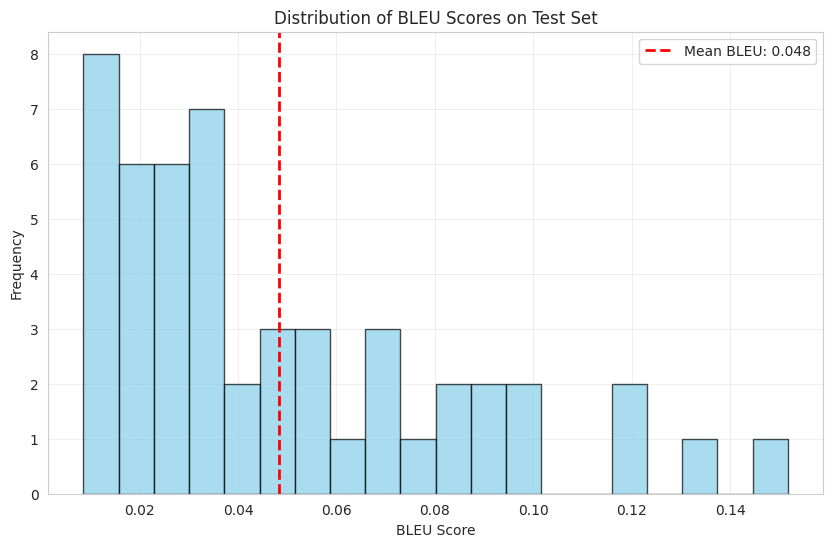

In [67]:
# Plot BLEU distribution
plt.figure(figsize=(10, 6))
plt.hist(bleu_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(bleu_scores), color='red', linestyle='--', linewidth=2,
            label=f'Mean BLEU: {np.mean(bleu_scores):.3f}')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('Distribution of BLEU Scores on Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [68]:
model_path = 'models/nutrigen_transformer_final.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': tokenizer.vocab_size,
    'd_model': model.d_model,
    'config': {
        'd_model': 256,
        'n_heads': 8,
        'n_layers': 4,  # You trained with 4 layers (0-3)
        'dropout': 0.1
    },
    'training_info': {
        'final_train_loss': 2.5071,
        'final_val_loss': 2.9306,
        'final_perplexity': 18.74,
        'epochs_trained': 20
    }
}, model_path)

# Save tokenizer
tokenizer_path = 'models/recipe_tokenizer.pkl'
tokenizer.save(tokenizer_path)

print(f" Model saved to: {model_path}")
print(f" Tokenizer saved to: {tokenizer_path}")

 Model saved to: models/nutrigen_transformer_final.pt
 Tokenizer saved to: models/recipe_tokenizer.pkl


In [69]:
class RecipeGenerator:
    """Complete pipeline for generating recipe instructions"""

    def __init__(self, model_path, tokenizer_path, device=None):
        # Setup device
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device

        print(f"Loading model on device: {self.device}")

        # Load tokenizer
        self.tokenizer = RecipeTokenizer.load(tokenizer_path)
        print(f" Loaded tokenizer (vocab size: {self.tokenizer.vocab_size:,})")

        # Load model
        checkpoint = torch.load(model_path, map_location=self.device)
        config = checkpoint['config']

        # Initialize model with correct architecture
        # Use FixedRecipeTransformer if that's what you trained with
        self.model = FixedRecipeTransformer(
            vocab_size=checkpoint['vocab_size'],
            d_model=config['d_model'],
            n_heads=config['n_heads'],
            n_layers=config['n_layers'],
            d_ff=1024,  # Match your training config
            dropout=config['dropout']
        )

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()

        # Print training info if available
        if 'training_info' in checkpoint:
            info = checkpoint['training_info']
            print(f" Model loaded (Perplexity: {info['final_perplexity']:.2f})")
        else:
            print(f" Model loaded")

    def _generate_with_sampling(self, src, max_length=200, temperature=0.8, top_p=0.9):
        """Generate with nucleus sampling"""

        sos_idx = self.tokenizer.word2idx[self.tokenizer.sos_token]
        eos_idx = self.tokenizer.word2idx[self.tokenizer.eos_token]
        pad_idx = self.tokenizer.word2idx[self.tokenizer.pad_token]

        generated = torch.tensor([[sos_idx]], dtype=torch.long).to(self.device)

        with torch.no_grad():
            # Create source mask
            src_mask = (src == pad_idx)

            for _ in range(max_length):
                # Create target mask
                tgt_mask = (generated == pad_idx)

                # Forward pass
                logits = self.model(src, generated, src_mask, tgt_mask)
                next_token_logits = logits[0, -1, :] / temperature

                # Nucleus (top-p) sampling
                sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)

                # Remove tokens with cumulative probability above threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
                sorted_indices_to_remove[0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                next_token_logits[indices_to_remove] = float('-inf')

                # Sample next token
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1).unsqueeze(0)

                # Append to sequence
                generated = torch.cat([generated, next_token], dim=1)

                # Stop at EOS
                if next_token.item() == eos_idx:
                    break

        return generated[0]

    def generate_recipe(self, ingredients_list, nutrition_info,
                       max_length=200, temperature=0.8, top_p=0.9):
        """
        Generate cooking instructions for given ingredients and nutrition

        Args:
            ingredients_list: List of ingredient strings
            nutrition_info: Dict with keys 'calories', 'protein', 'carbs', 'fat'
            max_length: Maximum length of generated instructions
            temperature: Sampling temperature (0.7-1.0, higher = more creative)
            top_p: Nucleus sampling threshold (0.8-0.95)

        Returns:
            Dict with 'ingredients', 'nutrition', and 'instructions'
        """

        # Format input
        ingredients_str = ', '.join(ingredients_list)
        nutrition_str = (
            f" [CALORIES: {nutrition_info['calories']:.0f}] "
            f"[PROTEIN: {nutrition_info['protein']:.1f}g] "
            f"[CARBS: {nutrition_info['carbs']:.1f}g] "
            f"[FAT: {nutrition_info['fat']:.1f}g]"
        )
        input_text = ingredients_str + nutrition_str

        # Encode input
        input_ids = self.tokenizer.encode(input_text, max_length=150, add_special_tokens=True)
        src = torch.tensor([input_ids], dtype=torch.long).to(self.device)

        # Generate
        generated_ids = self._generate_with_sampling(
            src,
            max_length=max_length,
            temperature=temperature,
            top_p=top_p
        )

        # Decode
        generated_text = self.tokenizer.decode(generated_ids.tolist(), skip_special_tokens=True)

        return {
            'ingredients': ingredients_list,
            'nutrition': nutrition_info,
            'instructions': generated_text
        }

    def generate_multiple(self, ingredients_list, nutrition_info,
                         n_samples=3, temperature=0.85):
        """Generate multiple recipe variations"""

        results = []
        for i in range(n_samples):
            result = self.generate_recipe(
                ingredients_list,
                nutrition_info,
                temperature=temperature,
                top_p=0.9
            )
            results.append(result)

        return results

In [70]:
generator = RecipeGenerator(model_path, tokenizer_path)

# Test case 1: Baking recipe
print("\n Test 1")

test_ingredients_1 = [
    "2 cups all-purpose flour",
    "1 cup sugar",
    "2 eggs",
    "1 cup milk",
    "2 teaspoons baking powder",
    "1 teaspoon vanilla extract"
]

test_nutrition_1 = {
    'calories': 320,
    'protein': 8.5,
    'carbs': 65.2,
    'fat': 6.8
}

result_1 = generator.generate_recipe(test_ingredients_1, test_nutrition_1, temperature=0.8)

print("\n Ingredients:")
for ing in result_1['ingredients']:
    print(f"  • {ing}")

print(f"\n Nutrition:")
print(f"  Calories: {result_1['nutrition']['calories']:.0f} kcal")
print(f"  Protein: {result_1['nutrition']['protein']:.1f}g")
print(f"  Carbs: {result_1['nutrition']['carbs']:.1f}g")
print(f"  Fat: {result_1['nutrition']['fat']:.1f}g")

print(f"\n Instructions:")
print(f"  {result_1['instructions']}")

Loading model on device: cuda
 Loaded tokenizer (vocab size: 7,609)
 Model loaded (Perplexity: 18.74)

 Test 1

 Ingredients:
  • 2 cups all-purpose flour
  • 1 cup sugar
  • 2 eggs
  • 1 cup milk
  • 2 teaspoons baking powder
  • 1 teaspoon vanilla extract

 Nutrition:
  Calories: 320 kcal
  Protein: 8.5g
  Carbs: 65.2g
  Fat: 6.8g

 Instructions:
  preheat oven to 350 degrees f ( 175 degrees c ) . grease a 9x13 inch baking dish . in a medium bowl , mix together the ground beef , sugar , and salt . stir in the eggs , one at a time , mixing well after each addition . mix in the flour , 12 teaspoon at a time , until well blended . transfer to the prepared baking dish . bake in the preheated oven for 25 minutes , or until lightly browned .
